<a href="https://colab.research.google.com/github/njoyce98/HAR-GraphGAN-Dissertation/blob/main/GCN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral

     |████████████████████████████████| 122kB 9.3MB/s 


In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model

from keras.layers import Lambda
from keras.layers import Activation

import spektral
from spektral.data import BatchLoader
from spektral.datasets import QM9
from spektral.layers import ECCConv, GlobalSumPool
import pickle

from google.colab import drive

import copy

import os
import math
import pandas as pd
import numpy as np
import pickle
import random
from numpy.random import randn
from numpy.random import randint

import matplotlib.pyplot as plt

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Custom dataset for training
#Takes in array of graphs and array of labels
class LabelDataset(spektral.data.dataset.Dataset):
  def __init__(self, graph_arr, labels, **kwargs):
        self.graph_arr = copy.deepcopy(graph_arr)
        self.labels = labels
        super().__init__(**kwargs)
  
  def read(self):
      for x in range(len(self.graph_arr)):
        self.graph_arr[x].y = self.labels[x]
      return np.asarray(self.graph_arr)
  
  def labels(self):
    output = []
    for x in self.graph_arr:
      output.append(x.y)
    return output

In [ ]:
#Custom dataset for training
#Takes in node values, adj matrix, weight matrix, labels
class FakeDataset(spektral.data.dataset.Dataset):
  def __init__(self, X, A, E, Y, **kwargs):
        self.X = X
        self.A = A
        self.E = E
        self.Y = Y
        super().__init__(**kwargs)
  
  def read(self):
      output = []
      for x in range(len(self.X)):
        graph = spektral.data.graph.Graph(x = self.X[x], a = self.A, e = self.E, y = self.Y[x])
        output.append(graph)
      return output

In [ ]:
#Dataset needed for reconstruction of pickle
class MyDataset(spektral.data.dataset.Dataset):
    def __init__(self, adj_matrix, wadj_matrix, df, **kwargs):
        self.adj_matrix = adj_matrix
        self.wadj_matrix = wadj_matrix
        self.df = df
        super().__init__(**kwargs)

    def read(self):
      output = []

      for row in range(0, len(self.df), 30):
        label = self.df.iloc[row]['Label']
        print("row label: "+ str(row) + ", " + str(label))
        nodes_data = []
        time_weights = []

        for row_between in range(row, row+30):
          if(row_between != row):
            time_weights.append(self.df.iloc[row_between]['Time'] - self.df.iloc[row_between-1]['Time'])
          for joint in range(20):
            node_d = []
            for xyz in range(3):
              n = 1+(joint*3 + xyz)
              node_d.append(self.df.iloc[row_between][n])
            nodes_data.append(node_d)

        #make weight adj matrix
        print("weights: " + str(time_weights))
        new_wadj_matrix = make_wadj_matrix30(self.wadj_matrix, time_weights)
        nodes_data = np.asarray(nodes_data)
        adj_matrix = np.asarray(self.adj_matrix)
        weight_adj_matrix = np.asarray(new_wadj_matrix).reshape(600, 600, 1)
        label = np.array([label])

        graph = spektral.data.graph.Graph(x = nodes_data, a = adj_matrix, e = weight_adj_matrix, y = label)
        output.append(graph)
      return output

In [ ]:
# with open('/content/drive/My Drive/Colab Notebooks/Datasets/MHAD_dataset.pickle', 'rb') as data:
#     loaded_dataset = pickle.load(data)

In [ ]:
# with open('/content/drive/My Drive/Colab Notebooks/Datasets/NTURGBD_dataset.pickle', 'rb') as data:
#     ntu_dataset = pickle.load(data)

In [ ]:
# load dataset from pickle
with open('/content/drive/My Drive/Colab Notebooks/Datasets/mhad_graphs30.pickle', 'rb') as data:
  mhad_dataset = pickle.load(data)

In [ ]:
# with open('/content/drive/My Drive/Colab Notebooks/Datasets/ntu_graphs30.pickle', 'rb') as data:
#   ntu_dataset = pickle.load(data)

In [ ]:
loaded_dataset = mhad_dataset

In [ ]:
learning_rate = 0.0001  # Learning rate
epochs = 20  # Number of training epochs
batch_size = 64 # Batch size
# Parameters
F = loaded_dataset.n_node_features  # Dimension of node features
S = loaded_dataset.n_edge_features  # Dimension of edge features
n_out = 6  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(loaded_dataset))
split = int(0.8 * len(loaded_dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = loaded_dataset[idx_tr], loaded_dataset[idx_te]

In [ ]:
# GCN Model
X_in = Input(shape=(600, F))
A_in = Input(shape=(600, 600))
E_in = Input(shape=(600, 600, S))

fe = spektral.layers.GCNConv(64, activation="relu")([X_in, A_in])
fe = tf.keras.layers.BatchNormalization()(fe)
fe = tf.keras.layers.Dropout(0.1)(fe)
fe = spektral.layers.GCNConv(128, activation="relu")([fe, A_in])
fe = tf.keras.layers.BatchNormalization()(fe)
fe = tf.keras.layers.Dropout(0.1)(fe)
fe = spektral.layers.GCNConv(256, activation="relu")([fe, A_in])
fe = tf.keras.layers.BatchNormalization()(fe)
fe = tf.keras.layers.Dropout(0.1)(fe)
fe = spektral.layers.GCNConv(512, activation="relu")([fe, A_in])
fe = tf.keras.layers.BatchNormalization()(fe)
fe = tf.keras.layers.Dropout(0.1)(fe)
fe = tf.keras.layers.Flatten()(fe)
fe = tf.keras.layers.Dense(32, activation='relu')(fe)
fe = tf.keras.layers.BatchNormalization()(fe)
fe = tf.keras.layers.Dropout(0.3)(fe)
output = Dense(n_out, activation="softmax")(fe)

model = Model(inputs=[X_in, A_in, E_in], outputs=output)
# Build model
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=tf.keras.metrics.SparseCategoricalAccuracy())
model.summary()
# plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/Model pics/GCN_model.png', show_shapes=True, show_layer_names=True)


# FIT MODEL
loader_tr = BatchLoader(dataset_tr, batch_size=batch_size)
model_history = model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=100)


# EVALUATE MODEL
print("Testing model")
loader_te = BatchLoader(dataset_te, batch_size=batch_size)
model_loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(model_loss))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 600, 3)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 600, 600)]   0                                            
__________________________________________________________________________________________________
gcn_conv_4 (GCNConv)            (None, 600, 64)      256         input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 600, 64)      256         gcn_conv_4[0][0]           

KeyboardInterrupt: ignored

# GCN-GAN

In [ ]:
F = loaded_dataset.n_node_features  # Dimension of node features
S = loaded_dataset.n_edge_features  # Dimension of edge features
n_out = 6  # Dimension of the target

In [ ]:
@tf.function
def train_on_batch(inputs, target):
    inputs = tf.Variable(inputs)
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
        acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc

In [ ]:
def define_discriminator(n_classes=6):

  X_in = Input(shape=(600, F))
  A_in = Input(shape=(600, 600))
  E_in = Input(shape=(600, 600, S))

  fe = spektral.layers.GCNConv(64)([X_in, A_in])
  fe = tf.keras.layers.LeakyReLU(0.1)(fe)
  fe = spektral.layers.GCNConv(128)([fe, A_in])
  fe = tf.keras.layers.LeakyReLU(0.1)(fe)
  fe = tf.keras.layers.BatchNormalization()(fe)
  fe = spektral.layers.GCNConv(256)([fe, A_in])
  fe = tf.keras.layers.LeakyReLU(0.1)(fe)
  fe = tf.keras.layers.BatchNormalization()(fe)
  fe = spektral.layers.GCNConv(512)([fe, A_in])
  fe = tf.keras.layers.LeakyReLU(0.1)(fe)
  fe = tf.keras.layers.BatchNormalization()(fe)
  fe = tf.keras.layers.Flatten()(fe)
  fe = tf.keras.layers.Dense(32, activation='relu')(fe)
  fe = tf.keras.layers.BatchNormalization()(fe)
  fe = tf.keras.layers.Dropout(0.3)(fe)
  out_layer = Dense(n_classes)(fe)

  d_out_layer = Lambda(custom_activation)(out_layer)
  d_model = Model(inputs=[X_in, A_in, E_in], outputs=d_out_layer)
  d_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9))

  c_out_layer = Activation('softmax')(out_layer)
  # define and compile supervised discriminator model
  c_model = Model(inputs=[X_in, A_in, E_in], outputs=c_out_layer)
  c_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9), metrics=['accuracy'])

  return d_model, c_model

In [ ]:
# Open precalculated matrices for graphs
with open('/content/drive/My Drive/Colab Notebooks/Datasets/mhad30fps_wadj_matr.pickle', 'rb') as data:
  mhad_wadj_matr = pickle.load(data)

with open('/content/drive/My Drive/Colab Notebooks/Datasets/mhad30fps_adj_matr.pickle', 'rb') as data:
  mhad_adj_matr = pickle.load(data)

In [ ]:
from keras import backend

In [ ]:
# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

In [ ]:
def define_generator(latent_dim, n_classes=6):
  in_label = Input(shape=(1,))
  li = tf.keras.layers.Embedding(n_classes, 30)(in_label)
  n_nodes = 15*10*1
  li = Dense(n_nodes)(li)
  li = tf.keras.layers.Reshape((15, 10, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 15 * 10 * 3
  gen = Dense(n_nodes, activation='relu')(in_lat)
  gen = tf.keras.layers.Reshape((15, 10, 384))(gen)


  merge = tf.keras.layers.Concatenate()([gen, li])
  # upsample to 14x14
  gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
  # output
  gen = tf.keras.layers.Conv2D(64, (4,4), activation='tanh', padding='same')(gen)
  gen = tf.keras.layers.Conv2D(128, (4,4), activation='tanh', padding='same')(gen)
  gen = tf.keras.layers.Conv2D(256, (4,4), activation='tanh', padding='same')(gen)
  gen = tf.keras.layers.Conv2D(512, (4,4), activation='tanh', padding='same')(gen)
  out_layer = tf.keras.layers.Conv2D(3, (15,10), activation='tanh', padding='same')(gen)
  out_layer = tf.keras.layers.Reshape((600, 3))(out_layer)
  # define model
  model = Model([in_lat, in_label], out_layer)
  return model

In [ ]:
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  gen_noise, gen_label = g_model.input
  gen_output = g_model.output
  # connect output from generator as input to discriminator
  gan_output = d_model([g_model.output, mhad_adj_matr, mhad_wadj_matr])
  # define gan model as taking noise and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = tf.keras.optimizers.Nadam(lr=0.0001, beta_1 = 0.9)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
def select_supervised_samples(dataset, n_samples=64, n_classes=6):
  X = dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples / n_classes)
  for i in range(n_classes):
    # get all images for this class
    X_with_class = []
    for z in range(len(X)):
      sample = X[z]
      if (int(sample.y) == i):
        X_with_class.append(sample)
    # choose random instances
    ix = random.sample(range(0, len(X_with_class)), n_per_class)
    # add to list
    [X_list.append(X_with_class[j]) for j in ix]
    [y_list.append(i) for j in ix]
  return np.asarray(X_list), np.asarray(y_list)

In [ ]:
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  try:
    images, labels = dataset
  except:
    images = dataset
    labels = []
    for i in images:
      labels.append(i.y)
  labels = np.array(labels)
  # choose random instances
  ix = random.sample(range(0, len(images)), n_samples)
  # select images and labels
  X = []
  labels = labels[ix]
  for z in ix:
    X.append(images[z])
  # generate class labels
  y = np.ones((n_samples, 1))
  return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
  # generate labels
	labels = randint(0, 6, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X_out = generator.predict([z_input, labels_input])
  # create class labels
  y = np.zeros((n_samples, 1))
  return [X_out, labels_input], y

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64):
  bat_per_epo = int(len(dataset) / n_batch)
  half_batch = int(n_batch / 2)
  X_sup, y_sup = select_supervised_samples(dataset)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
      batch_d = LabelDataset(Xsup_real, ysup_real)
      c_loader_tr = BatchLoader(batch_d, batch_size=half_batch)
      batch = c_loader_tr.__next__()
      inputs, target = batch
      c_loss, c_acc = c_model.train_on_batch(inputs, target)


      # get randomly selected 'real' samples
      [X_real, _], y_real = generate_real_samples(dataset, half_batch)
      batch_d_real = LabelDataset(X_real, y_real)
      d_loader_tr = BatchLoader(batch_d_real, batch_size=half_batch)
      batch = d_loader_tr.__next__()
      inputs, target = batch
      d_loss1 = d_model.train_on_batch(inputs, y_real)

      [X_fake, label_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      fake_dataset = FakeDataset(X_fake, mhad_adj_matr, mhad_wadj_matr, y_fake)      
      f_loader = BatchLoader(fake_dataset, batch_size=half_batch)      
      batch = f_loader.__next__()
      inputs, target = batch      
      d_loss2= d_model.train_on_batch(inputs, y_fake)
      
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save('cgan_generator.h5')
  d_model.save('cgan_discriminator.h5')
  c_model.save('cgan_classifier.h5')

In [ ]:
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
plot_model(d_model, to_file='/content/drive/My Drive/Colab Notebooks/Model pics/Gdisc_model.png', show_shapes=True, show_layer_names=True)
plot_model(c_model, to_file='/content/drive/My Drive/Colab Notebooks/Model pics/Gclass_model.png', show_shapes=True, show_layer_names=True)
# create the generator
g_model = define_generator(latent_dim)
plot_model(g_model, to_file='/content/drive/My Drive/Colab Notebooks/Model pics/Ggen_model.png', show_shapes=True, show_layer_names=True)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# train model
train(g_model, d_model, c_model, gan_model, loaded_dataset, latent_dim)

>1, c[2.914,6], d[0.038,2.859], g[0.144]
>1, c[0.881,69], d[0.048,2.434], g[0.136]
>1, c[0.528,78], d[0.047,2.580], g[0.129]
>1, c[0.437,78], d[0.034,2.612], g[0.127]
>1, c[0.494,91], d[0.030,2.623], g[0.119]
>2, c[0.250,94], d[0.024,2.573], g[0.120]
>2, c[0.242,94], d[0.041,2.507], g[0.126]
>2, c[0.173,100], d[0.032,2.355], g[0.128]
>2, c[0.226,94], d[0.032,2.418], g[0.121]
>2, c[0.223,97], d[0.025,2.238], g[0.120]
>3, c[0.192,97], d[0.026,2.237], g[0.119]
>3, c[0.175,97], d[0.022,2.280], g[0.118]
>3, c[0.166,97], d[0.037,2.342], g[0.117]
>3, c[0.207,97], d[0.038,2.234], g[0.113]
>3, c[0.149,100], d[0.031,2.134], g[0.109]
>4, c[0.121,100], d[0.034,2.411], g[0.113]
>4, c[0.100,100], d[0.028,2.313], g[0.115]
>4, c[0.119,100], d[0.032,2.302], g[0.100]
>4, c[0.086,100], d[0.037,2.236], g[0.094]
>4, c[0.093,100], d[0.021,2.170], g[0.101]
>5, c[0.082,100], d[0.024,2.266], g[0.100]
>5, c[0.114,100], d[0.028,2.251], g[0.100]
>5, c[0.079,100], d[0.027,2.316], g[0.090]
>5, c[0.066,100], d[0.022

# Generate result

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('cgan_generator.h5', compile = False)

Labels

'Clapping hands', 'Jumping in place', 'Punching', 'Sit down', 'Stand up', 'Throwing a ball'

In [ ]:
gen_label = 0

In [ ]:
actions = ['Clapping_hands', 'Jumping_in_place', 'Punching', 'Sit_down', 'Stand_up', 'Throwing_a_ball']

In [ ]:
latent_points, labels = generate_latent_points(100, 1)
X_fake = model.predict([latent_points, np.array([gen_label])])

y_fake = gen_label

In [ ]:
classif = load_model('cgan_classifier.h5', compile = False, custom_objects={'GCNConv': spektral.layers.GCNConv})

In [ ]:
X_fake.shape

(1, 600, 3)

In [ ]:
X_fake = X_fake.reshape(30,20,3)

In [ ]:
data = []
for x in X_fake:
  row = []
  for y in x:
    for z in y:
      row.append(z)
  data.append(row)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Datasets/MHAD_df30fps.pickle', 'rb') as raaa:
  mhad_df = pickle.load(raaa)

In [ ]:
headers = np.array(mhad_df.columns)[:-2]

In [ ]:
new_df = pd.DataFrame(data = data, columns = headers)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Datasets/mhad_time.pickle', 'rb') as data:
    time = pickle.load(data)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Datasets/MHAD_scaler.pickle', 'rb') as data:
    mhad_scaler = pickle.load(data)

In [ ]:
time_col = []
for x in range(30):
  time_col.append(time.iloc[x])

new_df['Time'] = time_col

new_X = mhad_scaler.inverse_transform(new_df)

new_h = headers.copy()
new_h = np.append(new_h, 'Time')

out_df = pd.DataFrame(data = new_X, columns = new_h)

In [ ]:
def label30(label):
  out = []
  for x in range(30):
    out.append(label)
  return out

In [ ]:
out_df['Label'] = label30(y_fake)

# Plot result to graph

In [ ]:
# Find the max and min of x, y, z for plotting graph

rows, cols = out_df.shape
size = 20
ymax = -1
ymin = 100
xmax = -1
xmin = 100
zmax = -1
zmin = 100

for x in range(size):
    n = 3*x+1
    if (out_df.iloc[:, n].max() > xmax):
        xmax = out_df.iloc[:, n].max()
    if (out_df.iloc[:, n+1].max() > ymax):
        ymax = out_df.iloc[:, n+1].max()
    if (out_df.iloc[:, n+2].max() > zmax):
        zmax = out_df.iloc[:, n+2].max()

    if (out_df.iloc[:, n].min() < xmin):
        xmin = out_df.iloc[:, n].min()
    if (out_df.iloc[:, n+1].min() < ymin):
        ymin = out_df.iloc[:, n+1].min()
    if (out_df.iloc[:, n+2].min() < zmin):
        zmin = out_df.iloc[:, n+2].min()

xrange = abs(xmax - xmin)
yrange = abs(ymax - ymin)
zrange = abs(zmax - zmin)

large_range = max(xrange, yrange, zrange)

largerange: 176.6575832264392


In [ ]:
# All joints in order
ntu_joints = ['Pelvis', 'Abs', 'Neck', 'Head', 'Left shoulder', 'Left elbow', 'Left forearm', 'Right shoulder',
 'Right elbow', 'Right forearm', 'Left hip', 'Left knee', 'Left ankle', 'Left toes', 'Right hip',
 'Right knee', 'Right ankle', 'Right toes', 'Left fingers', 'Right fingers']

# Joints that start an edge
start_nodes = ["Pelvis", "Abs", "Neck", "Abs", "Left shoulder", "Left elbow", "Left forearm", "Abs", "Right shoulder", "Right elbow", "Right forearm",
               "Pelvis", "Left hip", "Left knee", "Left ankle", "Pelvis", "Right hip", "Right knee", "Right ankle"]

# Joints that end an edge
end_nodes = ["Abs", "Neck", "Head", "Left shoulder", "Left elbow", "Left forearm", "Left fingers", "Right shoulder", "Right elbow", "Right forearm",
             "Right fingers", "Left hip", "Left knee", "Left ankle", "Left toes", "Right hip", "Right knee", "Right ankle", "Right toes"]

# Pairs between joints
pairs = []
for x in range(len(start_nodes)):
  pairs.append((start_nodes[x], end_nodes[x]))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

FileNotFoundError: ignored

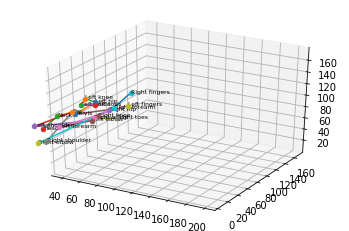

In [ ]:
#plot output as animated 3d graph

fig = plt.figure()
ax = plt.axes(projection='3d')

def clear_axes():
  ax.clear()
  ax.set_xlim(xmin, xmin+large_range)
  ax.set_ylim(zmin, zmin+large_range)
  ax.set_zlim(ymin, ymin+large_range)

def plot_frame(f):
  clear_axes()
  
  for x in ntu_joints:
    datax = out_df[x+".X"][f]
    datay = out_df[x+".Z"][f]
    dataz = out_df[x+".Y"][f]
    ax.scatter3D(datax, datay, dataz)
    ax.text(datax, datay, dataz, x, fontsize=6)
  
  for fst, sec in pairs:
    fx = out_df[fst + ".X"][f]
    fy = out_df[fst + ".Z"][f]
    fz = out_df[fst + ".Y"][f]

    sx = out_df[sec + ".X"][f]
    sy = out_df[sec + ".Z"][f]
    sz = out_df[sec + ".Y"][f]

    ax.plot([fx, sx], [fy, sy], [fz, sz])
    

ani = animation.FuncAnimation(fig, plot_frame, frames=30, interval=100, blit=False)
ani.save('/content/drive/My Drive/Colab Notebooks/Model outputs/GCN'  + str(actions[gen_label]) + '.gif', writer='pillow')

In [ ]:
# Plot animation as 5 frames next to eachother

fig2 = plt.figure(figsize=(25, 5))
axis1 = fig2.add_subplot(151, projection='3d')

axis2 = fig2.add_subplot(152, projection='3d')
axis3 = fig2.add_subplot(153, projection='3d')
axis4 = fig2.add_subplot(154, projection='3d')
axis5 = fig2.add_subplot(155, projection='3d')

def set_lims(ax):
  ax.set_xlim(xmin, xmin+large_range)
  ax.set_ylim(zmin, zmin+large_range)
  ax.set_zlim(ymin, ymin+large_range)

def plot_pics(f, axis):
  
  for x in ntu_joints:
    datax = out_df[x+".X"][f]
    datay = out_df[x+".Z"][f]
    dataz = out_df[x+".Y"][f]
    axis.scatter3D(datax, datay, dataz)
    axis.text(datax, datay, dataz, x, fontsize=6)
  
  for fst, sec in pairs:
    fx = out_df[fst + ".X"][f]
    fy = out_df[fst + ".Z"][f]
    fz = out_df[fst + ".Y"][f]

    sx = out_df[sec + ".X"][f]
    sy = out_df[sec + ".Z"][f]
    sz = out_df[sec + ".Y"][f]

    axis.plot([fx, sx], [fy, sy], [fz, sz])

frames = [0, 5, 11, 17, 23, 29]
axis = [axis1, axis2, axis3, axis4, axis5]
for x in range(5):
  plot_pics(frames[x], axis[x])

#fig2.savefig('/content/drive/My Drive/Colab Notebooks/Model outputs/GCN'  + str(actions[gen_label]) + 'FRAMES.png')